In [2]:
import numpy as np
import torch 
from torch.utils.data import DataLoader, random_split
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import os
import random
import copy
from collections import defaultdict
import time
import pickle

In [3]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


## 1. Data Preprocessing

In [4]:
def preprocessing(main_folder_path):
    # list of folders in the main folder
    listdir = sorted(os.listdir(main_folder_path))
    
    # Image Transformation
    mean = [0.485, 0.456, 0.406] # mean of image tensor
    std = [0.229, 0.224, 0.225]  # standard devisation of image tensor
    normalize_stat = (mean, std)
    size = 224

    transform = T.Compose([
        T.Resize(size),
        T.CenterCrop(size),
        T.ToTensor(),
        T.Normalize(*normalize_stat)
    ])

    dataset = ImageFolder(main_folder_path, transform=transform)
    classes = dataset.classes

    return dataset, classes

In [5]:
main_folder_path = '../input/pins-face-recognition/105_classes_pins_dataset'
dataset, classes = preprocessing(main_folder_path)

print("Total dataset size: ", len(dataset))
print("Number of classes: ", len(classes))

Total dataset size:  17534
Number of classes:  105


In [6]:
def dataloader(dataset, classes, train_batch_size, test_batch_size, num_clients):
    torch.manual_seed(42)
    
    # 70% to 30% train to test
    num_val = int(len(dataset) * 0.3)
    num_train = len(dataset) - num_val
    
    # 1. Train and Validation Data
    train_data, test_data = random_split(dataset, [num_train, num_val])
    
    # save train_data size (n)
    n = len(train_data)
    
    # Partition data for federated learning
    train_loader_list = []
    
    # nk / n list
    nk_n_list = []
    
    # Client ID: corresponding train_loader
    client_loader_dict = {}
    
    # Split train dataset
    total_train_size = len(train_data)
    examples_per_client = total_train_size // num_clients
    client_datasets = random_split(train_data, [min(i + examples_per_client, 
               total_train_size) - i for i in range(0, total_train_size, examples_per_client)])
    
    client_datasets = client_datasets[:num_clients]
    
    
    # Save dataloader for each
    for client_id, client_data in enumerate(client_datasets):
        
        # Save nk / n
        nk_n = len(client_data) / len(train_data)
        nk_n_list.append(nk_n)
        
        train_loader = DataLoader(client_data, batch_size=train_batch_size, shuffle=True, pin_memory=False, num_workers=3)
        train_loader_list.append(train_loader)
        client_loader_dict[client_id] = train_loader
    
    # Train and Validation Dataloader
    loader_idx = 0
    for key, _ in client_loader_dict.items():
        client_loader_dict[key] = train_loader_list[loader_idx]
        loader_idx += 1
    
    test_loader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False, pin_memory=False, num_workers=3)
    
    return train_loader_list, client_loader_dict, test_loader, test_data, nk_n_list

In [7]:
num_clients = 5
train_batch_size = 64
test_batch_size = 32

train_loader_list, client_loader_dict, test_loader, test_data, nk_n_list = dataloader(dataset, classes, train_batch_size, test_batch_size, num_clients)

for i in nk_n_list:
    print(i)

0.19993482157405898
0.19993482157405898
0.19993482157405898
0.19993482157405898
0.19993482157405898


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## 2. Model

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchsummary import summary
from glob import glob
from tqdm.notebook import tqdm

In [9]:
class black_box_model(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.resnet34 = models.resnet34(True)
        self.features = nn.Sequential(*list(self.resnet34.children())[:-1])
        # Replace last layer
        self.classifier = nn.Sequential(nn.Flatten(),
                                         nn.Linear(self.resnet34.fc.in_features, num_classes))

    def forward(self, x):
        x = self.features(x)
        y = self.classifier(x)
        return y
    
    def summary(self, input_size):
        return summary(self, input_size)

In [10]:
class white_box_model(nn.Module):
    def __init__(self, num_classes, dropout, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.dropout = dropout
        self.alexnet = models.alexnet(True)
        self.features = nn.Sequential(*list(self.alexnet.children())[:-1])
        
        # Replace last layer
        self.classifier = nn.Sequential(
            nn.Dropout(p=self.dropout),
            nn.Linear(6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=self.dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        y = self.classifier(x)
        return y
    
    def summary(self, input_size):
        return summary(self, input_size)

In [11]:
class white_box_model(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.resnet50 = models.resnet50(True)
        self.features = nn.Sequential(*list(self.resnet50.children())[:-1])
        # Replace last layer
        self.classifier = nn.Sequential(nn.Flatten(),
                                         nn.Linear(self.resnet50.fc.in_features, num_classes))

    def forward(self, x):
        x = self.features(x)
        y = self.classifier(x)
        return y
    
    def summary(self, input_size):
        return summary(self, input_size)

In [12]:
models.resnet34(True).fc.in_features

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

512

In [13]:
main_folder_path = '../input/pins-face-recognition/105_classes_pins_dataset'
dataset, classes = preprocessing(main_folder_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = len(classes)

global_model = black_box_model(num_classes=num_classes).to(device)
# global_model.summary((3, 224, 224))

In [14]:
main_folder_path = '../input/pins-face-recognition/105_classes_pins_dataset'
dataset, classes = preprocessing(main_folder_path)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = len(classes)

global_model = white_box_model(num_classes=num_classes).to(device)
global_model.summary((3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
            Conv2d-2         [-1, 64, 112, 112]           9,408
       BatchNorm2d-3         [-1, 64, 112, 112]             128
       BatchNorm2d-4         [-1, 64, 112, 112]             128
              ReLU-5         [-1, 64, 112, 112]               0
              ReLU-6         [-1, 64, 112, 112]               0
         MaxPool2d-7           [-1, 64, 56, 56]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]           4,096
           Conv2d-10           [-1, 64, 56, 56]           4,096
      BatchNorm2d-11           [-1, 64, 56, 56]             128
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
             ReLU-14           [-1, 64,

## 3. Federated Learning

In [15]:
# # Federated Averaging Algorithm (Non-IID)
# def fedAvg(w, nk_n_list, client_id_selected):
    
#     print("")
#     print("Averaging client_id list: ", client_id_selected)
    
#     first_id = client_id_selected[0]
#     w_avg = copy.deepcopy(w[first_id])
    
#     # Update first weight parameter
#     for k in w_avg.keys():
#         nk_n = nk_n_list[first_id]
#         w_avg[k] = w_avg[k] + (nk_n * w[first_id][k])
    
#     # Remove the updated id weight
#     client_id_selected.remove(first_id)
    
#     print("After removing first index: ", client_id_selected)
#     print("")
    
#     # Use selected client's weight parameters
#     for k in w_avg.keys():
#         for i in client_id_selected: 
#             nk_n = nk_n_list[i]
#             w_avg[k] = w_avg[k] + (nk_n * w[i][k])
        
#         w_avg[k] = torch.div(w_avg[k], len(w))
    
#     return w_avg

In [16]:
# FedAvg (iid-setting)
from collections import OrderedDict

def fedAvg(client_model_list, nk_n_list):
    new_params = OrderedDict()
    
    n = len(client_model_list)  # number of clients
    
    for client_model in client_model_list:
        local_param = client_model.state_dict()  # get current parameters of one client
        for k, v in local_param.items():
            new_params[k] = new_params.get(k, 0) + v / n
    
    return new_params

## 4. Clean Training and Evaluation

In [17]:
pip install torchattacks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.8/208.8 kB 1.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [18]:
from torchattacks import *

In [19]:
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

# Code Referance: https://www.kaggle.com/code/pezhmansamadi/facerecognition-torch-resnet34

def local_train(attack_id_selected, white_model, client_id, e, local_epochs, local_model, train_loader, device, criterion, optimizer):
    torch.cuda.empty_cache()
    local_model.train(True)
    torch.set_grad_enabled(True)
    
    # Due to black-box model setting
    # Use second party pre-trained model to create the adversarial example
    atk = FGSM(white_model, eps=8/255)
    
    if client_id in attack_id_selected:
        # Create adversarial example
        print("Adversarial Training on current device")
    
    total = 0
    correct = 0
    local_loss = 0.0
    local_acc = 0
    
    tq_batch = tqdm(train_loader, total=len(train_loader))
    for images, labels in tq_batch:
        images = images.to(device)
        labels = labels.to(device)
        
        # Attack if current id is the selected id
        if client_id in attack_id_selected:
            # Create adversarial example
            images = atk(images, labels)
            
        optimizer.zero_grad()
        outs = local_model(images)
        _, preds = torch.max(outs, 1)
        
        # outs = torch.exp(outs)
        loss = criterion(outs, labels)
        loss.backward()
        optimizer.step()
        local_loss += loss.item()
        
        total += labels.size(0)
        correct += (preds == labels).sum()
        local_acc += float(correct) / total
        
        tq_batch.set_description(f'Local Epoch [{e + 1}/{local_epochs}]')
        tq_batch.set_postfix_str('Local loss = {:.4f} ; Local acc = {:.4f} '.format(loss.item(), float(correct) / total))
    
    # Average loss and acc of the training batch
    local_acc = local_acc / len(train_loader)
    local_loss = local_loss / len(train_loader)
    local_w = local_model.state_dict()

    return local_model, local_loss, local_w, local_acc

def global_evaluate(global_model, test_loader, criterion, device):
    torch.cuda.empty_cache()
    global_model.eval()
    
    total = 0
    glob_loss = 0
    glob_acc = 0
    correct = 0
    
    tq_batch = tqdm(test_loader, total=len(test_loader), leave=False)
    for images, labels in tq_batch:
        images = images.to(device)
        labels = labels.to(device)

        outputs = global_model(images)
        loss = criterion(outputs, labels)
        glob_loss += loss.item()
        
        _, preds = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (preds == labels).sum()
        
        glob_acc += float(correct) / total
        batch_acc = float(correct) / total
        
        tq_batch.set_postfix_str('Global loss = {:.4f} ; Global acc = {:.4f} '.format(loss.item(), batch_acc))
    
    # Average global loss and acc of the batch
    glob_loss = glob_loss / len(test_loader)
    glob_acc = glob_acc / len(test_loader)

    return glob_acc, glob_loss

In [21]:
def federated_learning(num_attacks, white_model, num_selected, num_rounds, num_clients, num_local_epochs, global_model, client_model_list, client_loader_dict, device, nk_n_list):
    torch.cuda.empty_cache()
    
    id_loss_dict = defaultdict(list)
    id_acc_dict = defaultdict(list)
    update_count_dict = {}
    
    num_client_list = [i for i in range(num_clients)]
    for _client in num_client_list:
        update_count_dict[_client] = 0
        
    attack_id_selected = random.sample(num_client_list, k=num_attacks)
    
    print("Adversarial Training id selected: ", attack_id_selected)
    
    local_w_list = [None for i in range(num_clients)]
    local_loss_list = [100 for i in range(num_clients)]
    
    glob_acc_list = []
    glob_loss_list = []
    
    criterion = nn.CrossEntropyLoss()
    
    # For each round
    start_time = time.time()
    for each_round in tqdm(range(num_rounds)):
        print("Adversarial Training id selected: ", attack_id_selected)
        # Randomly selected client id "EACH ROUND"        
        # client_id_selected = num_client_list
        client_id_selected = random.sample(num_client_list, k=num_selected)
        print("Selected client_id: ", client_id_selected)
        
        # Increase count for number of updates
        for _id in client_id_selected:
            update_count_dict[_id] += 1
        
        # For each client
        start_time = time.time()
        client_count = 1
        for client_id in tqdm(client_id_selected):
            print("")
            print(f"Updating [client_id]: {client_id}")
            print("")
            local_model = client_model_list[client_id]
            local_dataloader = client_loader_dict[client_id]
            
            learning_rate = 0.05
            optimizer = torch.optim.SGD(local_model.parameters(), lr=learning_rate)
            
            # For each local epoch for each client
            for e in tqdm(range(num_local_epochs)):
                # Train local client models
                local_updated_model, new_local_loss, local_w, local_acc = local_train(attack_id_selected, 
                                                                                      white_model,
                                                                                      client_id,
                                                                                      e, 
                                                                                      num_local_epochs, 
                                                                                      local_model, 
                                                                                      local_dataloader, 
                                                                                      device, 
                                                                                      criterion, 
                                                                                      optimizer)
                current_loss = local_loss_list[client_id]
                
                # Save loss & acc for each client id
                id_loss_dict[client_id].append(new_local_loss)
                id_acc_dict[client_id].append(local_acc)
                
                # Append new local_loss and local_weight
                local_loss_list[client_id] = new_local_loss
                local_w_list[client_id] = local_w 
                
                print(f"[rounds]: {each_round + 1}/{num_rounds} - [client_count]: {client_count}/{num_selected} - [local_epoch]: {e+1}/{num_local_epochs} - [local_loss]: {new_local_loss} - [local_acc]: {local_acc*100}%")
            
            client_count += 1
            
        # Federaed Averaging
        # new_glob_w = fedAvg(local_w_list, nk_n_list, client_id_selected)
        new_glob_w = fedAvg(client_model_list, nk_n_list)
        global_model.load_state_dict(new_glob_w)
        
        # Send new global model back to clients
        print("")
        print("Sending global model weight to local client models...")
        print("")
        for loc_model in client_model_list:
            loc_model.load_state_dict(new_glob_w)
        
        # Evaluate Global Model
        glob_acc, glob_loss = global_evaluate(global_model, test_loader, criterion, device)
        glob_acc_list.append(glob_acc*100)
        glob_loss_list.append(glob_loss)
        
        print("")
        print("*"*100)
        print("")
        print(f"[rounds]: {each_round + 1}/{num_rounds} - [global_loss]: {glob_loss} - [global_acc]: {glob_acc*100}%")
        print("")
        print("*"*100)
        print("")
    
    # Show number of updates for each client
    print("")
    for __id, count in update_count_dict.items():
        print("Client {} updated count: {}".format(__id, count))
    print("")
    
    # Total time taken
    print("Time taken = {:.4f} minutes".format((time.time() - start_time) / 60))
    
    # Save Current Model
    pickle.dump(global_model, open('global_model.pkl', 'wb'))
    
    return global_model, glob_acc_list, glob_loss_list, id_loss_dict

In [22]:
main_folder_path = '../input/pins-face-recognition/105_classes_pins_dataset'
   
num_clients = 7
train_batch_size = 64
test_batch_size = 64

dataset, classes = preprocessing(main_folder_path=main_folder_path)
train_loader_list, client_loader_dict, test_loader, _, nk_n_list = dataloader(dataset, classes, train_batch_size, test_batch_size, num_clients)

for idx, dt in client_loader_dict.items():
    print(f'Client {idx} dataloader size: {len(dt)}')

print("")
print("Test dataloader size: ", len(test_loader))

Client 0 dataloader size: 28
Client 1 dataloader size: 28
Client 2 dataloader size: 28
Client 3 dataloader size: 28
Client 4 dataloader size: 28
Client 5 dataloader size: 28
Client 6 dataloader size: 28

Test dataloader size:  83


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [24]:
# num_selected = num_clients only for iid setting
num_selected = 5
num_rounds = 10
num_local_epochs = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
global_model = black_box_model(num_classes=num_classes).to(device)
client_model_list = [black_box_model(num_classes=num_classes).to(device) for _ in range(num_clients)]

# Model used to create adversarial examples
# AlexNet()
white_model = white_box_model(num_classes=num_classes).to(device)
num_attack = 1

start_time = time.time()
global_model, glob_acc_list, glob_loss_list, id_loss_dict = federated_learning(num_attack,
                                                                               white_model,
                                                                               num_selected,
                                                                               num_rounds, 
                                                                               num_clients, 
                                                                               num_local_epochs, 
                                                                               global_model, 
                                                                               client_model_list, 
                                                                               client_loader_dict, 
                                                                               device,
                                                                               nk_n_list)

print("Time taken = {:.4f} minutes".format((time.time() - start_time) / 60))

Adversarial Training id selected:  [0]


  0%|          | 0/10 [00:00<?, ?it/s]

Adversarial Training id selected:  [0]
Selected client_id:  [3, 4, 2, 6, 1]


  0%|          | 0/5 [00:00<?, ?it/s]


Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 1/5 - [local_epoch]: 1/5 - [local_loss]: 4.553553768566677 - [local_acc]: 2.527819960640119%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 1/5 - [local_epoch]: 2/5 - [local_loss]: 3.3096599834305898 - [local_acc]: 24.5055777961845%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 1/5 - [local_epoch]: 3/5 - [local_loss]: 2.112397394009999 - [local_acc]: 63.51095028094248%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 1/5 - [local_epoch]: 4/5 - [local_loss]: 1.1601549088954926 - [local_acc]: 89.0846288187356%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 1/5 - [local_epoch]: 5/5 - [local_loss]: 0.5066266453691891 - [local_acc]: 98.76755092435528%

Updating [client_id]: 4



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 2/5 - [local_epoch]: 1/5 - [local_loss]: 4.546210544449942 - [local_acc]: 2.1516439225057162%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 2/5 - [local_epoch]: 2/5 - [local_loss]: 3.2339321885790144 - [local_acc]: 29.58087145286462%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 2/5 - [local_epoch]: 3/5 - [local_loss]: 2.1041534670761655 - [local_acc]: 61.64765490855719%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 2/5 - [local_epoch]: 4/5 - [local_loss]: 1.185583506311689 - [local_acc]: 88.19261233975345%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 2/5 - [local_epoch]: 5/5 - [local_loss]: 0.5216754185301917 - [local_acc]: 98.39397348545003%

Updating [client_id]: 2



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 3/5 - [local_epoch]: 1/5 - [local_loss]: 4.526455232075283 - [local_acc]: 2.0621144877257858%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 3/5 - [local_epoch]: 2/5 - [local_loss]: 3.3110695481300354 - [local_acc]: 24.059284081360737%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 3/5 - [local_epoch]: 3/5 - [local_loss]: 2.112619021109172 - [local_acc]: 64.68936782779545%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 3/5 - [local_epoch]: 4/5 - [local_loss]: 1.1551529892853327 - [local_acc]: 86.79937329517068%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 3/5 - [local_epoch]: 5/5 - [local_loss]: 0.5033643990755081 - [local_acc]: 97.6538760343685%

Updating [client_id]: 6



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 4/5 - [local_epoch]: 1/5 - [local_loss]: 4.525404146739414 - [local_acc]: 1.5659761112947361%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 4/5 - [local_epoch]: 2/5 - [local_loss]: 3.266306391784123 - [local_acc]: 25.72961151070733%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 4/5 - [local_epoch]: 3/5 - [local_loss]: 2.1201579868793488 - [local_acc]: 63.08748163904552%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 4/5 - [local_epoch]: 4/5 - [local_loss]: 1.1219020805188589 - [local_acc]: 88.10957090592083%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 4/5 - [local_epoch]: 5/5 - [local_loss]: 0.48663836291858126 - [local_acc]: 99.46773636216311%

Updating [client_id]: 1



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 5/5 - [local_epoch]: 1/5 - [local_loss]: 4.535412873540606 - [local_acc]: 3.1524174141203587%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 5/5 - [local_epoch]: 2/5 - [local_loss]: 3.2665941204343523 - [local_acc]: 24.936422835626196%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 5/5 - [local_epoch]: 3/5 - [local_loss]: 2.096927068063191 - [local_acc]: 63.70935128111096%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 5/5 - [local_epoch]: 4/5 - [local_loss]: 1.1259375427450453 - [local_acc]: 90.99352929652204%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 1/10 - [client_count]: 5/5 - [local_epoch]: 5/5 - [local_loss]: 0.4902066056217466 - [local_acc]: 98.59862775517986%

Sending global model weight to local client models...



  0%|          | 0/83 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 1/10 - [global_loss]: 4.13157835925918 - [global_acc]: 11.55359786297707%

****************************************************************************************************

Adversarial Training id selected:  [0]
Selected client_id:  [2, 5, 4, 6, 3]


  0%|          | 0/5 [00:00<?, ?it/s]


Updating [client_id]: 2



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 1/5 - [local_epoch]: 1/5 - [local_loss]: 3.5402898703302657 - [local_acc]: 18.817284799511967%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 1/5 - [local_epoch]: 2/5 - [local_loss]: 2.473336773259299 - [local_acc]: 46.14212253242919%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 1/5 - [local_epoch]: 3/5 - [local_loss]: 1.4569574764796667 - [local_acc]: 75.90985444426536%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 1/5 - [local_epoch]: 4/5 - [local_loss]: 0.7199371435812542 - [local_acc]: 93.28348455130276%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 1/5 - [local_epoch]: 5/5 - [local_loss]: 0.3202282264828682 - [local_acc]: 99.47267046392959%

Updating [client_id]: 5



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 2/5 - [local_epoch]: 1/5 - [local_loss]: 3.6636773262705122 - [local_acc]: 14.434148801391617%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 2/5 - [local_epoch]: 2/5 - [local_loss]: 2.5799757412501743 - [local_acc]: 39.57893967029391%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 2/5 - [local_epoch]: 3/5 - [local_loss]: 1.6366523121084486 - [local_acc]: 71.16910983545405%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 2/5 - [local_epoch]: 4/5 - [local_loss]: 0.8733260120664325 - [local_acc]: 89.44280533155452%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 2/5 - [local_epoch]: 5/5 - [local_loss]: 0.39004685623305185 - [local_acc]: 98.35299093876148%

Updating [client_id]: 4



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 3/5 - [local_epoch]: 1/5 - [local_loss]: 3.5227936676570346 - [local_acc]: 22.899129323324317%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 3/5 - [local_epoch]: 2/5 - [local_loss]: 2.4290358083588734 - [local_acc]: 44.600784425341814%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 3/5 - [local_epoch]: 3/5 - [local_loss]: 1.4760449826717377 - [local_acc]: 77.50255685856052%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 3/5 - [local_epoch]: 4/5 - [local_loss]: 0.7430518077952522 - [local_acc]: 94.93817241622395%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 3/5 - [local_epoch]: 5/5 - [local_loss]: 0.33145196576203617 - [local_acc]: 99.31882157490189%

Updating [client_id]: 6



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 4/5 - [local_epoch]: 1/5 - [local_loss]: 3.538205461842673 - [local_acc]: 18.493383300931512%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 4/5 - [local_epoch]: 2/5 - [local_loss]: 2.4108292715890065 - [local_acc]: 48.81543354056053%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 4/5 - [local_epoch]: 3/5 - [local_loss]: 1.4359439952032906 - [local_acc]: 74.6897598415462%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 4/5 - [local_epoch]: 4/5 - [local_loss]: 0.6964115777185985 - [local_acc]: 94.3496717338661%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 4/5 - [local_epoch]: 5/5 - [local_loss]: 0.3068325812263148 - [local_acc]: 99.25073310518232%

Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 5/5 - [local_epoch]: 1/5 - [local_loss]: 3.527001202106476 - [local_acc]: 19.50974637159802%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 5/5 - [local_epoch]: 2/5 - [local_loss]: 2.4223200934273854 - [local_acc]: 46.754627029528315%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 5/5 - [local_epoch]: 3/5 - [local_loss]: 1.4594003856182098 - [local_acc]: 75.62372291309846%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 5/5 - [local_epoch]: 4/5 - [local_loss]: 0.7113276230437415 - [local_acc]: 95.27557079923638%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 2/10 - [client_count]: 5/5 - [local_epoch]: 5/5 - [local_loss]: 0.31543961060898645 - [local_acc]: 99.56988285694902%

Sending global model weight to local client models...



  0%|          | 0/83 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 2/10 - [global_loss]: 2.693757577114795 - [global_acc]: 45.78790425179678%

****************************************************************************************************

Adversarial Training id selected:  [0]
Selected client_id:  [4, 0, 1, 3, 2]


  0%|          | 0/5 [00:00<?, ?it/s]


Updating [client_id]: 4



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 1/5 - [local_epoch]: 1/5 - [local_loss]: 1.936228368963514 - [local_acc]: 61.18082687882629%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 1/5 - [local_epoch]: 2/5 - [local_loss]: 0.7627737522125244 - [local_acc]: 90.4910678632486%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 1/5 - [local_epoch]: 3/5 - [local_loss]: 0.2681795156427792 - [local_acc]: 99.39502761334245%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 1/5 - [local_epoch]: 4/5 - [local_loss]: 0.11725371863160815 - [local_acc]: 99.99374958607793%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 1/5 - [local_epoch]: 5/5 - [local_loss]: 0.07382434939167329 - [local_acc]: 100.0%

Updating [client_id]: 0



  0%|          | 0/5 [00:00<?, ?it/s]

Training with adversarial examples on current device


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 2/5 - [local_epoch]: 1/5 - [local_loss]: 3.2249461838177274 - [local_acc]: 18.16436199572939%
Training with adversarial examples on current device


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 2/5 - [local_epoch]: 2/5 - [local_loss]: 1.890788048505783 - [local_acc]: 56.62310468521133%
Training with adversarial examples on current device


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 2/5 - [local_epoch]: 3/5 - [local_loss]: 0.9154172922883715 - [local_acc]: 86.1045515286879%
Training with adversarial examples on current device


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 2/5 - [local_epoch]: 4/5 - [local_loss]: 0.38471551558801104 - [local_acc]: 97.37530826170067%
Training with adversarial examples on current device


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 2/5 - [local_epoch]: 5/5 - [local_loss]: 0.18274849812899316 - [local_acc]: 99.05730882730327%

Updating [client_id]: 1



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 3/5 - [local_epoch]: 1/5 - [local_loss]: 2.251830735376903 - [local_acc]: 47.3723055569558%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 3/5 - [local_epoch]: 2/5 - [local_loss]: 0.9890475038971219 - [local_acc]: 83.62375997535058%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 3/5 - [local_epoch]: 3/5 - [local_loss]: 0.37263263761997223 - [local_acc]: 98.61545827746525%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 3/5 - [local_epoch]: 4/5 - [local_loss]: 0.1525778163756643 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 3/5 - [local_epoch]: 5/5 - [local_loss]: 0.08272596927625793 - [local_acc]: 100.0%

Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 4/5 - [local_epoch]: 1/5 - [local_loss]: 1.8926427619797843 - [local_acc]: 62.01878237398128%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 4/5 - [local_epoch]: 2/5 - [local_loss]: 0.7187112420797348 - [local_acc]: 92.70866045985154%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 4/5 - [local_epoch]: 3/5 - [local_loss]: 0.2531525774725846 - [local_acc]: 99.68776871572148%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 4/5 - [local_epoch]: 4/5 - [local_loss]: 0.11251974584800857 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 4/5 - [local_epoch]: 5/5 - [local_loss]: 0.0744302671934877 - [local_acc]: 100.0%

Updating [client_id]: 2



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 5/5 - [local_epoch]: 1/5 - [local_loss]: 1.9095801327909743 - [local_acc]: 61.18653285943102%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 5/5 - [local_epoch]: 2/5 - [local_loss]: 0.7452331887824195 - [local_acc]: 91.0304396583423%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 5/5 - [local_epoch]: 3/5 - [local_loss]: 0.26011841531310764 - [local_acc]: 99.63234821021081%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 5/5 - [local_epoch]: 4/5 - [local_loss]: 0.12016801456255573 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 3/10 - [client_count]: 5/5 - [local_epoch]: 5/5 - [local_loss]: 0.07454676300819431 - [local_acc]: 100.0%

Sending global model weight to local client models...



  0%|          | 0/83 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 3/10 - [global_loss]: 1.854509760098285 - [global_acc]: 59.55562066257303%

****************************************************************************************************

Adversarial Training id selected:  [0]
Selected client_id:  [4, 2, 5, 3, 6]


  0%|          | 0/5 [00:00<?, ?it/s]


Updating [client_id]: 4



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 1/5 - [local_epoch]: 1/5 - [local_loss]: 1.1247247542653764 - [local_acc]: 79.4783891723531%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 1/5 - [local_epoch]: 2/5 - [local_loss]: 0.2705538437834808 - [local_acc]: 98.96628481366201%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 1/5 - [local_epoch]: 3/5 - [local_loss]: 0.09059542178043298 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 1/5 - [local_epoch]: 4/5 - [local_loss]: 0.055571996340794225 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 1/5 - [local_epoch]: 5/5 - [local_loss]: 0.039386978040316274 - [local_acc]: 100.0%

Updating [client_id]: 2



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 2/5 - [local_epoch]: 1/5 - [local_loss]: 1.1293803368295943 - [local_acc]: 80.42757699366018%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 2/5 - [local_epoch]: 2/5 - [local_loss]: 0.2687100539250033 - [local_acc]: 98.01519156118026%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 2/5 - [local_epoch]: 3/5 - [local_loss]: 0.08812765311449766 - [local_acc]: 99.99796267622851%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 2/5 - [local_epoch]: 4/5 - [local_loss]: 0.05414891588900771 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 2/5 - [local_epoch]: 5/5 - [local_loss]: 0.039306531593735726 - [local_acc]: 100.0%

Updating [client_id]: 5



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 3/5 - [local_epoch]: 1/5 - [local_loss]: 1.5511686929634638 - [local_acc]: 64.51177813822451%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 3/5 - [local_epoch]: 2/5 - [local_loss]: 0.4537941440939903 - [local_acc]: 92.66141354937916%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 3/5 - [local_epoch]: 3/5 - [local_loss]: 0.12677269615232944 - [local_acc]: 99.60934355734496%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 3/5 - [local_epoch]: 4/5 - [local_loss]: 0.0674679780911122 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 3/5 - [local_epoch]: 5/5 - [local_loss]: 0.044159608493958204 - [local_acc]: 100.0%

Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 4/5 - [local_epoch]: 1/5 - [local_loss]: 1.0743268706968852 - [local_acc]: 80.68904567770578%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 4/5 - [local_epoch]: 2/5 - [local_loss]: 0.2766279061990125 - [local_acc]: 97.64953478276925%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 4/5 - [local_epoch]: 3/5 - [local_loss]: 0.08630337832229477 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 4/5 - [local_epoch]: 4/5 - [local_loss]: 0.052134883989180834 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 4/5 - [local_epoch]: 5/5 - [local_loss]: 0.0384979909285903 - [local_acc]: 100.0%

Updating [client_id]: 6



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 5/5 - [local_epoch]: 1/5 - [local_loss]: 1.4142519703933172 - [local_acc]: 69.33874503634861%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 5/5 - [local_epoch]: 2/5 - [local_loss]: 0.3740304128399917 - [local_acc]: 95.83757491712078%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 5/5 - [local_epoch]: 3/5 - [local_loss]: 0.10998182717178549 - [local_acc]: 99.78080549133722%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 5/5 - [local_epoch]: 4/5 - [local_loss]: 0.06051155884883234 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 4/10 - [client_count]: 5/5 - [local_epoch]: 5/5 - [local_loss]: 0.045248674894017835 - [local_acc]: 100.0%

Sending global model weight to local client models...



  0%|          | 0/83 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 4/10 - [global_loss]: 1.388278520250895 - [global_acc]: 68.19947066328551%

****************************************************************************************************

Adversarial Training id selected:  [0]
Selected client_id:  [0, 1, 4, 2, 6]


  0%|          | 0/5 [00:00<?, ?it/s]


Updating [client_id]: 0



  0%|          | 0/5 [00:00<?, ?it/s]

Training with adversarial examples on current device


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 1/5 - [local_epoch]: 1/5 - [local_loss]: 2.3615287201745168 - [local_acc]: 39.16246039178042%
Training with adversarial examples on current device


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 1/5 - [local_epoch]: 2/5 - [local_loss]: 0.7552749982901982 - [local_acc]: 82.22544360920283%
Training with adversarial examples on current device


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 1/5 - [local_epoch]: 3/5 - [local_loss]: 0.20230029736246383 - [local_acc]: 98.44747077058975%
Training with adversarial examples on current device


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 1/5 - [local_epoch]: 4/5 - [local_loss]: 0.09027267939278058 - [local_acc]: 99.61315609772588%
Training with adversarial examples on current device


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 1/5 - [local_epoch]: 5/5 - [local_loss]: 0.061174256061869006 - [local_acc]: 99.72507260944862%

Updating [client_id]: 1



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 2/5 - [local_epoch]: 1/5 - [local_loss]: 1.1668189551149095 - [local_acc]: 71.17586338947265%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 2/5 - [local_epoch]: 2/5 - [local_loss]: 0.2435292319527694 - [local_acc]: 97.03987293137342%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 2/5 - [local_epoch]: 3/5 - [local_loss]: 0.06361185573041439 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 2/5 - [local_epoch]: 4/5 - [local_loss]: 0.042106771642076116 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 2/5 - [local_epoch]: 5/5 - [local_loss]: 0.029814287155334438 - [local_acc]: 100.0%

Updating [client_id]: 4



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 3/5 - [local_epoch]: 1/5 - [local_loss]: 0.6389287827270371 - [local_acc]: 89.72981691185701%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 3/5 - [local_epoch]: 2/5 - [local_loss]: 0.15345554213438714 - [local_acc]: 99.14319484450232%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 3/5 - [local_epoch]: 3/5 - [local_loss]: 0.04757149424403906 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 3/5 - [local_epoch]: 4/5 - [local_loss]: 0.03233315536220159 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 3/5 - [local_epoch]: 5/5 - [local_loss]: 0.025490234273352792 - [local_acc]: 100.0%

Updating [client_id]: 2



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 4/5 - [local_epoch]: 1/5 - [local_loss]: 0.6080818293350083 - [local_acc]: 91.68916807467158%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 4/5 - [local_epoch]: 2/5 - [local_loss]: 0.1382572419409241 - [local_acc]: 98.89265675185469%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 4/5 - [local_epoch]: 3/5 - [local_loss]: 0.048246059965874465 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 4/5 - [local_epoch]: 4/5 - [local_loss]: 0.030829610569136485 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 4/5 - [local_epoch]: 5/5 - [local_loss]: 0.025655924209526608 - [local_acc]: 100.0%

Updating [client_id]: 6



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 5/5 - [local_epoch]: 1/5 - [local_loss]: 0.8965528011322021 - [local_acc]: 82.09966491563392%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 5/5 - [local_epoch]: 2/5 - [local_loss]: 0.20798238526497567 - [local_acc]: 96.89836113048325%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 5/5 - [local_epoch]: 3/5 - [local_loss]: 0.054238516704312394 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 5/5 - [local_epoch]: 4/5 - [local_loss]: 0.03486306359991431 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 5/10 - [client_count]: 5/5 - [local_epoch]: 5/5 - [local_loss]: 0.027108763743724142 - [local_acc]: 100.0%

Sending global model weight to local client models...



  0%|          | 0/83 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 5/10 - [global_loss]: 1.2024859419788223 - [global_acc]: 71.76078852850814%

****************************************************************************************************

Adversarial Training id selected:  [0]
Selected client_id:  [6, 3, 2, 0, 4]


  0%|          | 0/5 [00:00<?, ?it/s]


Updating [client_id]: 6



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 1/5 - [local_epoch]: 1/5 - [local_loss]: 0.5218431981546539 - [local_acc]: 90.74858016031166%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 1/5 - [local_epoch]: 2/5 - [local_loss]: 0.11420198050992829 - [local_acc]: 98.91050844381351%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 1/5 - [local_epoch]: 3/5 - [local_loss]: 0.037011450223092525 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 1/5 - [local_epoch]: 4/5 - [local_loss]: 0.025104219825672253 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 1/5 - [local_epoch]: 5/5 - [local_loss]: 0.019850991599793946 - [local_acc]: 100.0%

Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 2/5 - [local_epoch]: 1/5 - [local_loss]: 0.5755528296743121 - [local_acc]: 88.79516849238806%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 2/5 - [local_epoch]: 2/5 - [local_loss]: 0.11850610322185925 - [local_acc]: 99.27595764803074%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 2/5 - [local_epoch]: 3/5 - [local_loss]: 0.04119173976193581 - [local_acc]: 99.89706293181341%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 2/5 - [local_epoch]: 4/5 - [local_loss]: 0.023823255273912634 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 2/5 - [local_epoch]: 5/5 - [local_loss]: 0.020107663502650603 - [local_acc]: 100.0%

Updating [client_id]: 2



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 3/5 - [local_epoch]: 1/5 - [local_loss]: 0.32051949894854 - [local_acc]: 96.16522242011104%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 3/5 - [local_epoch]: 2/5 - [local_loss]: 0.08548563213220664 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 3/5 - [local_epoch]: 3/5 - [local_loss]: 0.03138665542272585 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 3/5 - [local_epoch]: 4/5 - [local_loss]: 0.02233155244695289 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 3/5 - [local_epoch]: 5/5 - [local_loss]: 0.018320833332836628 - [local_acc]: 100.0%

Updating [client_id]: 0



  0%|          | 0/5 [00:00<?, ?it/s]

Training with adversarial examples on current device


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 4/5 - [local_epoch]: 1/5 - [local_loss]: 1.761883863380977 - [local_acc]: 55.37690867112987%
Training with adversarial examples on current device


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 4/5 - [local_epoch]: 2/5 - [local_loss]: 0.470337766621794 - [local_acc]: 88.50432564671938%
Training with adversarial examples on current device


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 4/5 - [local_epoch]: 3/5 - [local_loss]: 0.11285530922136136 - [local_acc]: 99.0893594727909%
Training with adversarial examples on current device


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 4/5 - [local_epoch]: 4/5 - [local_loss]: 0.05503150913864374 - [local_acc]: 99.67881208782352%
Training with adversarial examples on current device


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 4/5 - [local_epoch]: 5/5 - [local_loss]: 0.04282404874850597 - [local_acc]: 99.8719488237102%

Updating [client_id]: 4



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 5/5 - [local_epoch]: 1/5 - [local_loss]: 0.3355753432427134 - [local_acc]: 95.8541010808189%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 5/5 - [local_epoch]: 2/5 - [local_loss]: 0.07838145696691104 - [local_acc]: 99.41288788332969%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 5/5 - [local_epoch]: 3/5 - [local_loss]: 0.0319930695529495 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 5/5 - [local_epoch]: 4/5 - [local_loss]: 0.02432247923154916 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 6/10 - [client_count]: 5/5 - [local_epoch]: 5/5 - [local_loss]: 0.018213531501325115 - [local_acc]: 100.0%

Sending global model weight to local client models...



  0%|          | 0/83 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 6/10 - [global_loss]: 1.106809262769768 - [global_acc]: 73.1016112862864%

****************************************************************************************************

Adversarial Training id selected:  [0]
Selected client_id:  [4, 3, 2, 5, 1]


  0%|          | 0/5 [00:00<?, ?it/s]


Updating [client_id]: 4



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 1/5 - [local_epoch]: 1/5 - [local_loss]: 0.16846147419086524 - [local_acc]: 98.55975244587583%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 1/5 - [local_epoch]: 2/5 - [local_loss]: 0.04454597391720329 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 1/5 - [local_epoch]: 3/5 - [local_loss]: 0.022261813515797257 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 1/5 - [local_epoch]: 4/5 - [local_loss]: 0.01777294820307621 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 1/5 - [local_epoch]: 5/5 - [local_loss]: 0.014417426328041725 - [local_acc]: 100.0%

Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 2/5 - [local_epoch]: 1/5 - [local_loss]: 0.3082588330975601 - [local_acc]: 93.91905278485486%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 2/5 - [local_epoch]: 2/5 - [local_loss]: 0.06485698252384152 - [local_acc]: 99.70111991124585%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 2/5 - [local_epoch]: 3/5 - [local_loss]: 0.02426996035501361 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 2/5 - [local_epoch]: 4/5 - [local_loss]: 0.019124330387317708 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 2/5 - [local_epoch]: 5/5 - [local_loss]: 0.015032995991142733 - [local_acc]: 100.0%

Updating [client_id]: 2



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 3/5 - [local_epoch]: 1/5 - [local_loss]: 0.1597560186471258 - [local_acc]: 98.9371174891474%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 3/5 - [local_epoch]: 2/5 - [local_loss]: 0.0445476799671139 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 3/5 - [local_epoch]: 3/5 - [local_loss]: 0.023570740994598185 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 3/5 - [local_epoch]: 4/5 - [local_loss]: 0.01653763691761664 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 3/5 - [local_epoch]: 5/5 - [local_loss]: 0.01448808893162225 - [local_acc]: 100.0%

Updating [client_id]: 5



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 4/5 - [local_epoch]: 1/5 - [local_loss]: 0.9429760958467212 - [local_acc]: 78.715762423218%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 4/5 - [local_epoch]: 2/5 - [local_loss]: 0.18223620418991363 - [local_acc]: 96.09891790066224%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 4/5 - [local_epoch]: 3/5 - [local_loss]: 0.040478812131498544 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 4/5 - [local_epoch]: 4/5 - [local_loss]: 0.02257878752425313 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 4/5 - [local_epoch]: 5/5 - [local_loss]: 0.017301119531371763 - [local_acc]: 100.0%

Updating [client_id]: 1



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 5/5 - [local_epoch]: 1/5 - [local_loss]: 0.71114752973829 - [local_acc]: 82.88565984446745%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 5/5 - [local_epoch]: 2/5 - [local_loss]: 0.1278424710035324 - [local_acc]: 98.50416198031937%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 5/5 - [local_epoch]: 3/5 - [local_loss]: 0.0331473048510296 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 5/5 - [local_epoch]: 4/5 - [local_loss]: 0.02065621702266591 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 7/10 - [client_count]: 5/5 - [local_epoch]: 5/5 - [local_loss]: 0.017401830393022726 - [local_acc]: 100.0%

Sending global model weight to local client models...



  0%|          | 0/83 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 7/10 - [global_loss]: 0.9354224686163017 - [global_acc]: 77.06208699161873%

****************************************************************************************************

Adversarial Training id selected:  [0]
Selected client_id:  [6, 3, 1, 4, 5]


  0%|          | 0/5 [00:00<?, ?it/s]


Updating [client_id]: 6



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 1/5 - [local_epoch]: 1/5 - [local_loss]: 0.2216857671737671 - [local_acc]: 97.56616760692013%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 1/5 - [local_epoch]: 2/5 - [local_loss]: 0.060555972691093175 - [local_acc]: 99.63979193461253%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 1/5 - [local_epoch]: 3/5 - [local_loss]: 0.022447443966354643 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 1/5 - [local_epoch]: 4/5 - [local_loss]: 0.016146286756598523 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 1/5 - [local_epoch]: 5/5 - [local_loss]: 0.011911194705005203 - [local_acc]: 100.0%

Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 2/5 - [local_epoch]: 1/5 - [local_loss]: 0.12892118442271436 - [local_acc]: 99.2301814413256%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 2/5 - [local_epoch]: 2/5 - [local_loss]: 0.03804639607135739 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 2/5 - [local_epoch]: 3/5 - [local_loss]: 0.019886958146733896 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 2/5 - [local_epoch]: 4/5 - [local_loss]: 0.014149015636316367 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 2/5 - [local_epoch]: 5/5 - [local_loss]: 0.01261954621544906 - [local_acc]: 100.0%

Updating [client_id]: 1



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 3/5 - [local_epoch]: 1/5 - [local_loss]: 0.3466400073042938 - [local_acc]: 95.64165739118057%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 3/5 - [local_epoch]: 2/5 - [local_loss]: 0.09824841336480208 - [local_acc]: 98.33479753279309%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 3/5 - [local_epoch]: 3/5 - [local_loss]: 0.024169536640069315 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 3/5 - [local_epoch]: 4/5 - [local_loss]: 0.01701047893480531 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 3/5 - [local_epoch]: 5/5 - [local_loss]: 0.013207629090175033 - [local_acc]: 100.0%

Updating [client_id]: 4



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 4/5 - [local_epoch]: 1/5 - [local_loss]: 0.08762142833854471 - [local_acc]: 99.64237434694542%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 4/5 - [local_epoch]: 2/5 - [local_loss]: 0.027131915292037383 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 4/5 - [local_epoch]: 3/5 - [local_loss]: 0.0186272434491132 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 4/5 - [local_epoch]: 4/5 - [local_loss]: 0.014634229974555117 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 4/5 - [local_epoch]: 5/5 - [local_loss]: 0.012409584397183997 - [local_acc]: 100.0%

Updating [client_id]: 5



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 5/5 - [local_epoch]: 1/5 - [local_loss]: 0.4799516573548317 - [local_acc]: 91.91673076597594%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 5/5 - [local_epoch]: 2/5 - [local_loss]: 0.11560724742178406 - [local_acc]: 98.55356380507763%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 5/5 - [local_epoch]: 3/5 - [local_loss]: 0.03629101925928678 - [local_acc]: 99.95193840630516%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 5/5 - [local_epoch]: 4/5 - [local_loss]: 0.024740188349304453 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 8/10 - [client_count]: 5/5 - [local_epoch]: 5/5 - [local_loss]: 0.013374835286023361 - [local_acc]: 100.0%

Sending global model weight to local client models...



  0%|          | 0/83 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 8/10 - [global_loss]: 0.8659762833491865 - [global_acc]: 78.40735563874685%

****************************************************************************************************

Adversarial Training id selected:  [0]
Selected client_id:  [3, 0, 4, 6, 1]


  0%|          | 0/5 [00:00<?, ?it/s]


Updating [client_id]: 3



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 1/5 - [local_epoch]: 1/5 - [local_loss]: 0.0665415907278657 - [local_acc]: 99.73907380383142%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 1/5 - [local_epoch]: 2/5 - [local_loss]: 0.027492697683296034 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 1/5 - [local_epoch]: 3/5 - [local_loss]: 0.016974049420761212 - [local_acc]: 99.94425238050955%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 1/5 - [local_epoch]: 4/5 - [local_loss]: 0.012166656320914626 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 1/5 - [local_epoch]: 5/5 - [local_loss]: 0.011024317571095057 - [local_acc]: 100.0%

Updating [client_id]: 0



  0%|          | 0/5 [00:00<?, ?it/s]

Training with adversarial examples on current device


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 2/5 - [local_epoch]: 1/5 - [local_loss]: 1.4864172978060586 - [local_acc]: 58.063736759413246%
Training with adversarial examples on current device


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 2/5 - [local_epoch]: 2/5 - [local_loss]: 0.2727875815970557 - [local_acc]: 93.27818844342987%
Training with adversarial examples on current device


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 2/5 - [local_epoch]: 3/5 - [local_loss]: 0.060847124617014615 - [local_acc]: 99.67709689001788%
Training with adversarial examples on current device


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 2/5 - [local_epoch]: 4/5 - [local_loss]: 0.03524333647718387 - [local_acc]: 99.78027150700413%
Training with adversarial examples on current device


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 2/5 - [local_epoch]: 5/5 - [local_loss]: 0.027560587540002807 - [local_acc]: 99.73985515733584%

Updating [client_id]: 4



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 3/5 - [local_epoch]: 1/5 - [local_loss]: 0.06155449378171137 - [local_acc]: 99.75800112016522%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 3/5 - [local_epoch]: 2/5 - [local_loss]: 0.02348619353558336 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 3/5 - [local_epoch]: 3/5 - [local_loss]: 0.015383540286815591 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 3/5 - [local_epoch]: 4/5 - [local_loss]: 0.012437827386228102 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 3/5 - [local_epoch]: 5/5 - [local_loss]: 0.010317568384510065 - [local_acc]: 100.0%

Updating [client_id]: 6



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 4/5 - [local_epoch]: 1/5 - [local_loss]: 0.10827303624578885 - [local_acc]: 99.63052510268422%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 4/5 - [local_epoch]: 2/5 - [local_loss]: 0.03345753824604409 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 4/5 - [local_epoch]: 3/5 - [local_loss]: 0.01644149512451674 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 4/5 - [local_epoch]: 4/5 - [local_loss]: 0.012739177793264389 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 4/5 - [local_epoch]: 5/5 - [local_loss]: 0.010763416249704148 - [local_acc]: 100.0%

Updating [client_id]: 1



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 5/5 - [local_epoch]: 1/5 - [local_loss]: 0.1263888188238655 - [local_acc]: 99.14588535015334%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 5/5 - [local_epoch]: 2/5 - [local_loss]: 0.040316498173134666 - [local_acc]: 99.98157221327605%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 5/5 - [local_epoch]: 3/5 - [local_loss]: 0.017716365600270883 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 5/5 - [local_epoch]: 4/5 - [local_loss]: 0.013225357879751496 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 9/10 - [client_count]: 5/5 - [local_epoch]: 5/5 - [local_loss]: 0.01078859402332455 - [local_acc]: 100.0%

Sending global model weight to local client models...



  0%|          | 0/83 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 9/10 - [global_loss]: 0.8633374069110457 - [global_acc]: 78.17803514161606%

****************************************************************************************************

Adversarial Training id selected:  [0]
Selected client_id:  [5, 1, 0, 2, 4]


  0%|          | 0/5 [00:00<?, ?it/s]


Updating [client_id]: 5



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 1/5 - [local_epoch]: 1/5 - [local_loss]: 0.2668052629700729 - [local_acc]: 96.45271469167584%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 1/5 - [local_epoch]: 2/5 - [local_loss]: 0.07919476360880903 - [local_acc]: 98.84054372510457%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 1/5 - [local_epoch]: 3/5 - [local_loss]: 0.019896994777289883 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 1/5 - [local_epoch]: 4/5 - [local_loss]: 0.012926900992169976 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 1/5 - [local_epoch]: 5/5 - [local_loss]: 0.010053939884528518 - [local_acc]: 100.0%

Updating [client_id]: 1



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 2/5 - [local_epoch]: 1/5 - [local_loss]: 0.06920422527140804 - [local_acc]: 99.86451084848007%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 2/5 - [local_epoch]: 2/5 - [local_loss]: 0.023195857714329447 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 2/5 - [local_epoch]: 3/5 - [local_loss]: 0.015937403243567263 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 2/5 - [local_epoch]: 4/5 - [local_loss]: 0.011229963673810874 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 2/5 - [local_epoch]: 5/5 - [local_loss]: 0.01022906498318272 - [local_acc]: 100.0%

Updating [client_id]: 0



  0%|          | 0/5 [00:00<?, ?it/s]

Training with adversarial examples on current device


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 3/5 - [local_epoch]: 1/5 - [local_loss]: 1.0124353425843375 - [local_acc]: 73.30655157975328%
Training with adversarial examples on current device


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 3/5 - [local_epoch]: 2/5 - [local_loss]: 0.17805404641798564 - [local_acc]: 96.17662292551647%
Training with adversarial examples on current device


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 3/5 - [local_epoch]: 3/5 - [local_loss]: 0.04536724602803588 - [local_acc]: 99.74478435081997%
Training with adversarial examples on current device


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 3/5 - [local_epoch]: 4/5 - [local_loss]: 0.0263115764329476 - [local_acc]: 99.63878755424233%
Training with adversarial examples on current device


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 3/5 - [local_epoch]: 5/5 - [local_loss]: 0.02119150441805167 - [local_acc]: 99.76384242234226%

Updating [client_id]: 2



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 4/5 - [local_epoch]: 1/5 - [local_loss]: 0.1000071983518345 - [local_acc]: 99.1061984571841%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 4/5 - [local_epoch]: 2/5 - [local_loss]: 0.03605005856869476 - [local_acc]: 99.78080549133722%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 4/5 - [local_epoch]: 3/5 - [local_loss]: 0.014640088924872023 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 4/5 - [local_epoch]: 4/5 - [local_loss]: 0.01055691552548004 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 4/5 - [local_epoch]: 5/5 - [local_loss]: 0.008638456580229104 - [local_acc]: 100.0%

Updating [client_id]: 4



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 5/5 - [local_epoch]: 1/5 - [local_loss]: 0.040284380316734314 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 5/5 - [local_epoch]: 2/5 - [local_loss]: 0.01778771372378937 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 5/5 - [local_epoch]: 3/5 - [local_loss]: 0.013027441721143467 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 5/5 - [local_epoch]: 4/5 - [local_loss]: 0.009993096431052046 - [local_acc]: 100.0%


  0%|          | 0/28 [00:00<?, ?it/s]

[rounds]: 10/10 - [client_count]: 5/5 - [local_epoch]: 5/5 - [local_loss]: 0.008680294001741069 - [local_acc]: 100.0%

Sending global model weight to local client models...



  0%|          | 0/83 [00:00<?, ?it/s]


****************************************************************************************************

[rounds]: 10/10 - [global_loss]: 0.8476014489150909 - [global_acc]: 78.35994920267343%

****************************************************************************************************


Client 0 updated count: 5
Client 1 updated count: 7
Client 2 updated count: 8
Client 3 updated count: 8
Client 4 updated count: 10
Client 5 updated count: 5
Client 6 updated count: 7

Time taken = 4.1050 minutes
Time taken = 38.4876 minutes


## 5. Visualization

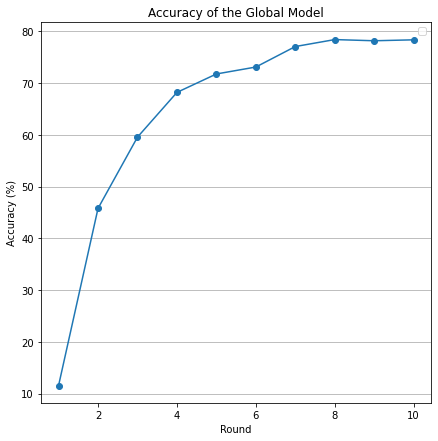

In [26]:
# global_acc_list = [26.716984038791264, 60.15311546396437, 73.3554127190271, 77.58730917267368, 80.73023665495782, 80.09354952848075,  81.32439079295223]

import matplotlib.pyplot as plt

num_round_list = list(range(1, num_rounds+1))
# glob_acc_list = [i*100 for i in glob_acc_list]

plt.figure(figsize=(7, 7))
plt.grid(axis='y')
plt.title("Accuracy of the Global Model")
plt.xlabel("Round")
plt.ylabel("Accuracy (%)")

plt.plot(num_round_list, glob_acc_list, '-o')
plt.legend()

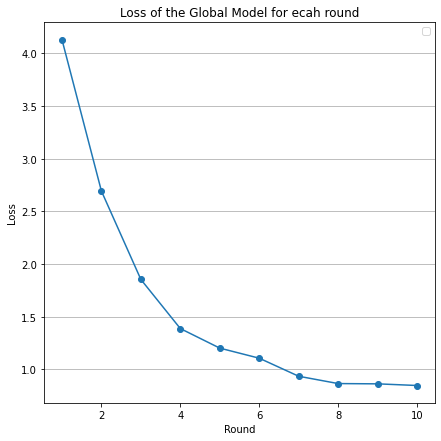

In [27]:
import matplotlib.pyplot as plt

num_round_list = list(range(1, num_rounds+1))

plt.figure(figsize=(7, 7))
plt.grid(axis='y')
plt.title("Loss of the Global Model for ecah round")
plt.xlabel("Round")
plt.ylabel("Loss")

plt.plot(num_round_list, glob_loss_list, '-o')
plt.legend()

In [ ]:
# import matplotlib.pyplot as plt

# total_iter_per_client = num_local_epochs * num_rounds
# client_id_list = list(range(0, num_clients))
# total_iter_list = list(range(1, total_iter_per_client+1))

# plt.figure(figsize=(7, 7))
# plt.grid(axis='y')
# plt.title("Average Loss of each client")
# plt.xlabel("Iteration")
# plt.ylabel("Loss of each client")

# for client_id in client_id_list:
#     plt.plot(total_iter_list, id_loss_dict[client_id], label=("Client_id={}".format(client_id)))
#     plt.legend()

In [ ]:
# import matplotlib.pyplot as plt

# total_iter_per_client = num_local_epochs * num_rounds
# client_id_list = list(range(0, num_clients))
# total_iter_list = list(range(1, total_iter_per_client+1))

# plt.figure(figsize=(7, 7))
# plt.grid(axis='y')
# plt.title("Average Accuracy of each client")
# plt.xlabel("Num rounds")
# plt.ylabel("Accuracy (%)")

# for client_id in client_id_list:
#     plt.plot(total_iter_list, id_acc_dict[client_id], label=("Client_id={}".format(client_id)))
#     plt.legend()

## 6. Standard and Robust Accuracy

### 6.1 Standard Accuracy

In [28]:
# atk = FGSM(model, eps=8/255)
torch.cuda.empty_cache()
global_model.eval()
criterion = nn.CrossEntropyLoss()

total = 0
glob_loss = 0
glob_acc = 0
correct = 0

tq_batch = tqdm(test_loader, total=len(test_loader), leave=False)
for images, labels in tq_batch:
    images = images.to(device)
    labels = labels.to(device)

    outputs = global_model(images)
    loss = criterion(outputs, labels)
    glob_loss += loss.item()

    _, preds = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (preds == labels).sum()

    glob_acc += float(correct) / total
    batch_acc = float(correct) / total

    tq_batch.set_postfix_str('Global loss = {:.4f} ; Global acc = {:.4f} '.format(loss.item(), batch_acc))

# Average global loss and acc of the batch
glob_loss = glob_loss / len(test_loader)
glob_acc = glob_acc / len(test_loader)

print("Global loss: ", glob_loss)
print("Global accuracy: ", glob_acc)

  0%|          | 0/83 [00:00<?, ?it/s]

Global loss:  0.8476014489150909
Global accuracy:  0.7835994920267344


### 6.2 Robust Accuracy

In [30]:
atk = FGSM(global_model, eps=8/255)

torch.cuda.empty_cache()
global_model.eval()
criterion = nn.CrossEntropyLoss()

total = 0
glob_loss = 0
glob_acc = 0
correct = 0

tq_batch = tqdm(test_loader, total=len(test_loader), leave=False)
for images, labels in tq_batch:
    images = images.to(device)
    labels = labels.to(device)
    
    # Attack the model
    images = atk(images, labels)

    outputs = global_model(images)
    loss = criterion(outputs, labels)
    glob_loss += loss.item()

    _, preds = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (preds == labels).sum()

    glob_acc += float(correct) / total
    batch_acc = float(correct) / total

    tq_batch.set_postfix_str('Global loss = {:.4f} ; Robust acc = {:.4f} '.format(loss.item(), batch_acc))

# Average global loss and acc of the batch
glob_loss = glob_loss / len(test_loader)
glob_acc = glob_acc / len(test_loader)

print("Global loss: ", glob_loss)
print("Global accuracy: ", glob_acc)

  0%|          | 0/83 [00:00<?, ?it/s]

Global loss:  4.751029428229274
Global accuracy:  0.10274164270181817
